In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [166]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
urls = [
    "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
    "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
]

Using device: cpu


In [167]:



df_colnames = pd.read_csv(urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']
df = pd.read_csv(urls[0], header=None, names=df_colnames['f_names'].values)

df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

labels = np.where(df['status'] == 'normal.', 1, 0)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(samples)

norm_samples = df_scaled[labels == 1]
attack_samples = df_scaled[labels == 0]


In [168]:

# Split dataset
len_norm = len(norm_samples)
X_train = norm_samples[:int(0.8 * len_norm)]
X_test_norm = norm_samples[int(0.8 * len_norm):]
X_test_attack = attack_samples[:len(X_test_norm)]
X_test = np.concatenate([X_test_norm, X_test_attack])
y_test = np.ones(len(X_test))
y_test[:len(X_test_norm)] = 0

In [169]:

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)

# Prepare DataLoader
X_train_final, X_val = train_test_split(X_train, test_size=0.1, random_state=42)
train_dataset = TensorDataset(torch.FloatTensor(X_train_final))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True)

val_dataset = TensorDataset(torch.FloatTensor(X_val))
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True)

In [170]:



# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dim)
        )
        self.fc_mu = nn.Linear(intermediate_dim, latent_dim)
        self.fc_var = nn.Linear(intermediate_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, intermediate_dim),
            nn.ReLU(),
            nn.BatchNorm1d(intermediate_dim),
            nn.Linear(intermediate_dim, input_dim),
            nn.Sigmoid()
        )
        self.apply(self._init_weights)  # Apply weight initialization

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Define Loss Function
def vae_loss_fn(recon_x, x, mu, log_var):
    BCE = nn.BCELoss()(recon_x, x)
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [171]:

# Model setup
original_dim = X_train.shape[1]
intermediate_dim = original_dim // 2
latent_dim = original_dim // 3
model = VAE(original_dim, intermediate_dim, latent_dim).to(device)

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)


In [172]:


# Training loop
n_epochs = 50
losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        data = batch[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = vae_loss_fn(recon_batch, data, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}')
    scheduler.step(avg_loss)  # Adjust learning rate dynamically


Epoch 1/50, Loss: 0.4365
Epoch 2/50, Loss: 0.0779
Epoch 3/50, Loss: 0.0678
Epoch 4/50, Loss: 0.0650
Epoch 5/50, Loss: 0.0640
Epoch 6/50, Loss: 0.0632
Epoch 7/50, Loss: 0.0621
Epoch 8/50, Loss: 0.0603
Epoch 9/50, Loss: 0.0589
Epoch 10/50, Loss: 0.0585
Epoch 11/50, Loss: 0.0580
Epoch 12/50, Loss: 0.0577
Epoch 13/50, Loss: 0.0575
Epoch 14/50, Loss: 0.0576
Epoch 15/50, Loss: 0.0574
Epoch 16/50, Loss: 0.0572
Epoch 17/50, Loss: 0.0571
Epoch 18/50, Loss: 0.0571
Epoch 19/50, Loss: 0.0569
Epoch 20/50, Loss: 0.0571
Epoch 21/50, Loss: 0.0569
Epoch 22/50, Loss: 0.0568
Epoch 23/50, Loss: 0.0570
Epoch 24/50, Loss: 0.0568
Epoch 25/50, Loss: 0.0567
Epoch 26/50, Loss: 0.0566
Epoch 27/50, Loss: 0.0567
Epoch 28/50, Loss: 0.0567
Epoch 29/50, Loss: 0.0565
Epoch 30/50, Loss: 0.0567
Epoch 31/50, Loss: 0.0565
Epoch 32/50, Loss: 0.0564
Epoch 33/50, Loss: 0.0566
Epoch 34/50, Loss: 0.0566
Epoch 35/50, Loss: 0.0566
Epoch 36/50, Loss: 0.0565
Epoch 37/50, Loss: 0.0565
Epoch 38/50, Loss: 0.0564
Epoch 39/50, Loss: 0.

In [173]:


# Get reconstruction errors
def get_reconstruction_error(model, data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.FloatTensor(data).to(device)
        recon, _, _ = model(data_tensor)
        return np.mean(np.abs(data - recon.cpu().numpy()), axis=1)

train_errors = get_reconstruction_error(model, X_train)
test_errors = get_reconstruction_error(model, X_test)
error_thresh = np.quantile(train_errors, 0.95)
anomalies = test_errors > error_thresh

In [174]:


# Classification Report
print(classification_report(y_test, anomalies))



              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     19456
         1.0       0.87      0.89      0.88     19456

    accuracy                           0.88     38912
   macro avg       0.88      0.88      0.88     38912
weighted avg       0.88      0.88      0.88     38912



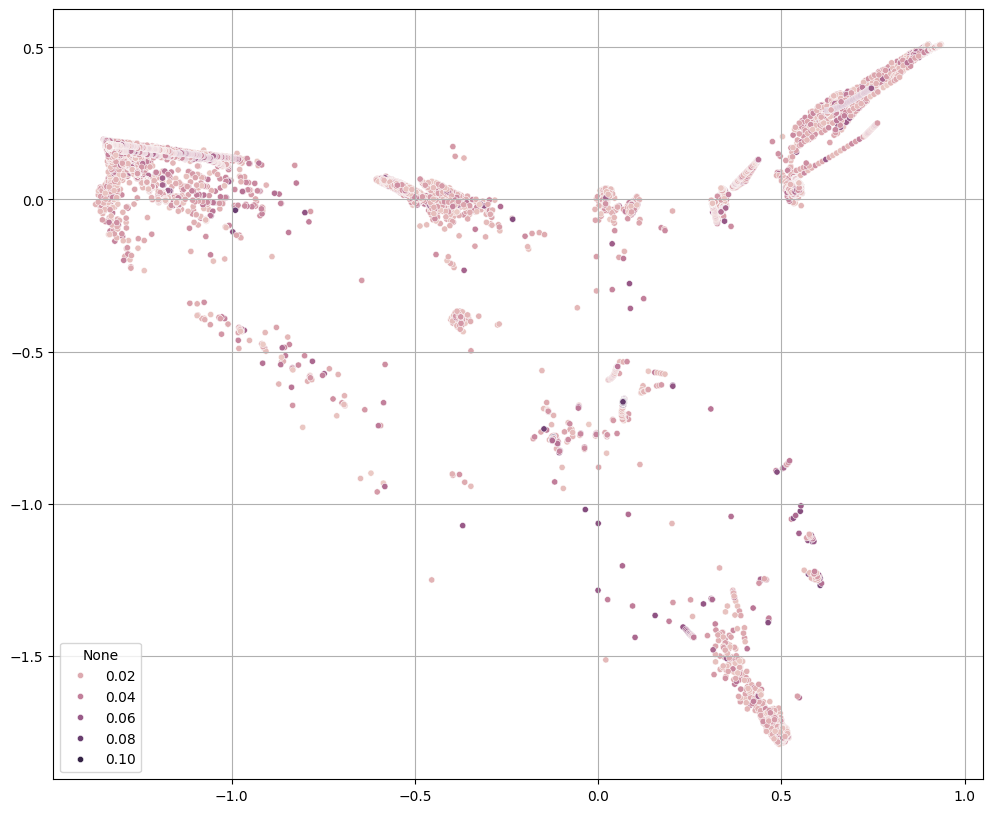

In [175]:
# Define function to get model outputs
def get_model_outputs(model, data):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.FloatTensor(data).to(device)
        recon_batch, mu, _ = model(data_tensor)
        return recon_batch.cpu().numpy(), mu.cpu().numpy()

# Get both predictions and encoded representations
X_pred, X_encoded = get_model_outputs(model, X_test)

# Ensure X_encoded is a 2D array for PCA
if len(X_encoded.shape) == 1:
    X_encoded = X_encoded.reshape(-1, 1)

# Apply PCA
pca = PCA(n_components=2)
X_transform = pca.fit_transform(X_encoded)

mae_vector_subset = mae_vector[:X_transform.shape[0]]

# Plot results
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector_subset)
plt.grid()
plt.show()


In [176]:
print(f"X_transform shape: {X_transform.shape}")
print(f"mae_vector length: {len(mae_vector)}")


X_transform shape: (38912, 2)
mae_vector length: 77822


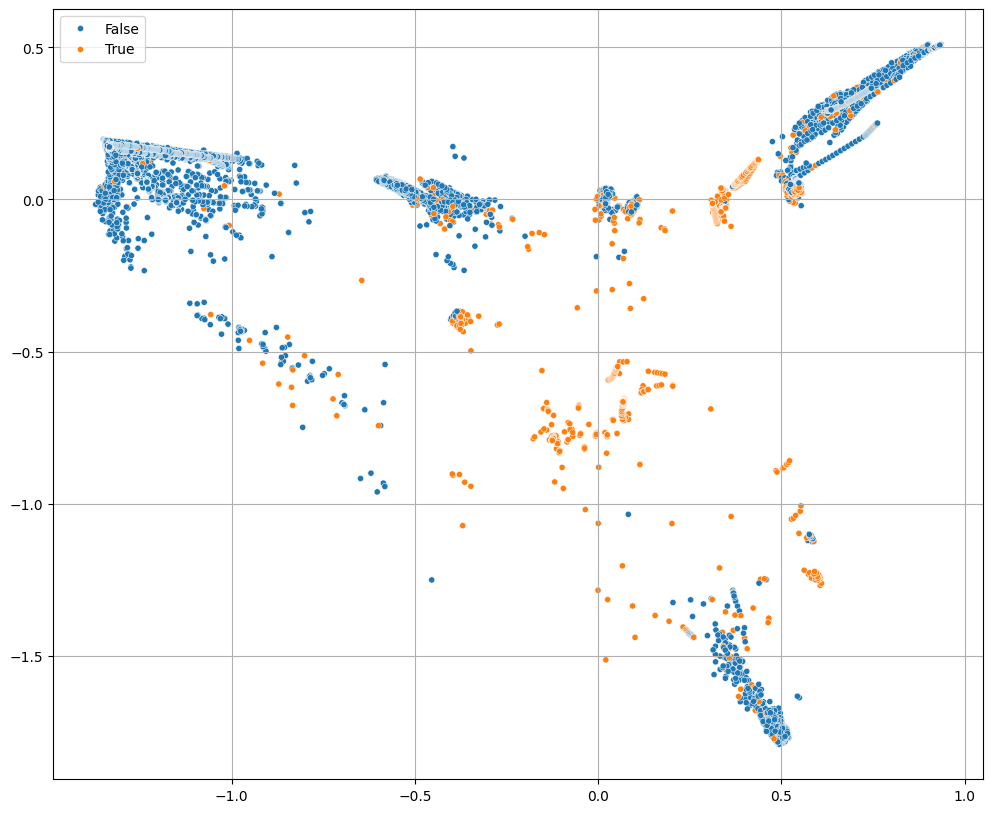

In [177]:

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()